<a href="https://colab.research.google.com/github/IndraniMandal/CSC310-S20/blob/master/notes/22b-digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e ds-assets && cd ds-assets && git pull && cd ..
# if it is not installed clone it
!test ! -e ds-assets && git clone https://github.com/IndraniMandal/ds-assets.git
# point to the folder with the assets
home = "ds-assets/assets/"
import sys
sys.path.append(home)      # add home folder to module search path

Cloning into 'ds-assets'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 205 (delta 54), reused 50 (delta 50), pack-reused 147 (from 1)
Receiving objects: 100% (205/205), 12.58 MiB | 11.01 MiB/s, done.
Resolving deltas: 100% (80/80), done.


# Handwritten Digit Recognition

This is based on the NIST optical character dataset available at [UCI](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits).

The dataset consist of 8x8 pixel images of handwritten digits:

<center>

![image](https://scipy-lectures.org/_images/sphx_glr_plot_digits_simple_classif_001.png)

</center>

The images themselves are stored as **pixel vectors of length 64**.  Each pixel is an integer value indicating a gray scale value.

We will build two models of the data:

1. A **clustering model** using kmeans -- to see if the digits forms a recoverable cluster structure in 64 dimensional space.

1. A **classification model** using decision trees -- to see if we can use the features in 64 dimensional space to classify the handwritten digits.

In [2]:
# we need UCI repo access
!pip install ucimlrepo

In [3]:
import pandas as pd
import numpy as np # we need numpy arrays
from ucimlrepo import fetch_ucirepo

# The NIST Character Dataset

In [4]:
# fetch dataset
digits = fetch_ucirepo(id=80)

# data (as pandas dataframes)
X = digits.data.features
y = digits.data.targets

## Examine Standard Dataset Characteristics

In [5]:
X.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute55,Attribute56,Attribute57,Attribute58,Attribute59,Attribute60,Attribute61,Attribute62,Attribute63,Attribute64
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,0,6,14,7,1,0,0
1,0,0,10,16,6,0,0,0,0,7,...,3,0,0,0,10,16,15,3,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,0,9,14,0,0,0,0
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,0,1,15,2,0,0
4,0,0,5,14,4,0,0,0,0,0,...,12,0,0,0,4,12,14,7,0,0


In [6]:
X.shape

(5620, 64)

In [7]:
y.head()

,class
0,0
1,0
2,7
3,4
4,6


In [8]:
y.value_counts()

,count
class,
3,572
1,571
4,568
7,566
9,562
5,558
6,558
2,557
0,554


## Look at the First Five Digits as Images

In [9]:
import matplotlib.pyplot as plt

In [10]:
y.head(n=5)

,class
0,0
1,0
2,7
3,4
4,6


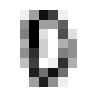

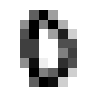

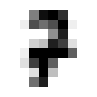

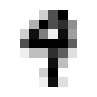

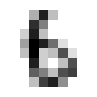

In [11]:
for i in range(5):
  im = np.array(X.iloc[i,]).reshape(8,8)
  plt.figure(figsize = (4,1))
  plt.axis('off')
  plt.imshow(im, cmap=plt.cm.binary, interpolation='nearest')
  plt.show()

# The Cluster Model

Given that there are 10 digits we would expect to see 10 clusters in the 64 dimensional space.  Let's check that with the elbow method.

In [12]:
from elbow import plot_elbow

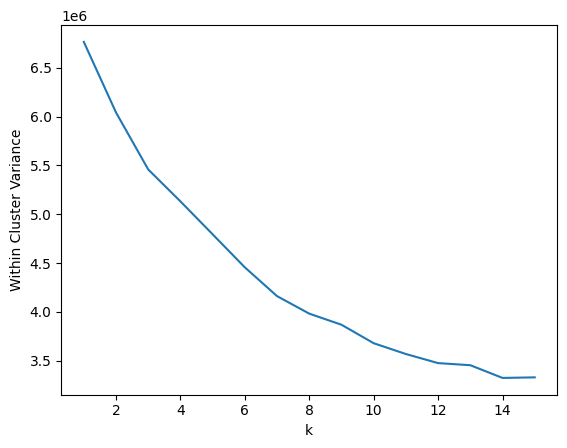

In [13]:
plot_elbow(X, n=15)

**Observation**: We can see that k=10 is at the upper end of the "elbow".

## The Kmeans Model

Now, we know that we want to compute a cluster model with,

In [14]:
k=10

under the assumption that **each cluster centroid will represent one of the digits**.

Let's try it.

In [15]:
from sklearn.cluster import KMeans

In [16]:
model = KMeans(n_clusters=k,
               n_init='auto',
               random_state=0)
model.fit(X)
model.cluster_centers_.shape

(10, 64)

As expected, we have 10 centroids embedded in the 64 dimensional space of the training data.

## Visualizing the Centroids

Recall that each point in the 64 dimensional space represents a handwritten digit.  That means, each of the cluster centroids has to represent a digit.  We can check that by reshaping the 1-dimensional coordinate vectors of the centroids into 8x8 bit maps.

In [17]:
# let's check the data type of the centroids
type(model.cluster_centers_[0,])

numpy.ndarray

In [18]:
# centroids are vectors
model.cluster_centers_[0,].shape

(64,)

In [19]:
digit_images =[]

In [20]:
# reshaping the centroid vectors into 8x8 bit maps
for i in range(k):
  digit_images.append(model.cluster_centers_[i,].reshape(8,8))

In [21]:
digit_images[0].shape

(8, 8)

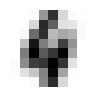

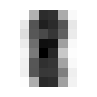

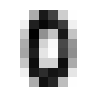

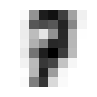

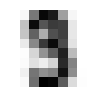

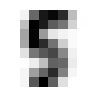

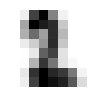

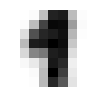

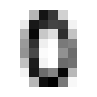

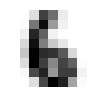

In [22]:
# display the images of the centroids
for i in range(k):
  plt.figure(figsize = (4,1))
  plt.axis('off')
  plt.imshow(digit_images[i], cmap=plt.cm.binary, interpolation='nearest')
  plt.show()

**Observation**: All the digits are clearly readable with the exception for the second last one which represent the digit 8.  Also, note that none of the digits are missing or repeated.

# Digit Classification Model

We will build a classification model based on decision trees.

In [23]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from confint import classification_confint
from sklearn.model_selection import train_test_split

In [24]:
# setting up training/testing data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.8,
    test_size=0.2,
    random_state=1
)

In [25]:
# finding the best model
model = tree.DecisionTreeClassifier(random_state=1)

param_grid = {
    'max_depth': list(range(1,21)), # search 1..20
    'criterion': ['entropy', 'gini', 'log_loss']
    }
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train,y_train)
print("Best parameters: {}".format(grid.best_params_))

# compute the accuracy of optimal classifier
predict_y = grid.best_estimator_.predict(X_test)
acc = accuracy_score(y_test, predict_y)
lb,ub = classification_confint(acc, X_test.shape[0])
print("Accuracy of best classifier: {:.2f} ({:.2f}, {:.2f})".format(acc, lb, ub))

Best parameters: {'criterion': 'entropy', 'max_depth': 10}
Accuracy of best classifier: 0.92 (0.90, 0.93)


In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
# build and print the confusion matrix
cm = confusion_matrix(y_test, predict_y)
cm_df = pd.DataFrame(cm)
cm_df

,0,1,2,3,4,5,6,7,8,9
0,104,0,0,0,0,0,0,1,0,0
1,0,120,1,2,2,0,0,0,1,4
2,1,1,80,2,0,0,0,1,4,2
3,0,0,0,108,0,3,0,1,1,5
4,0,1,0,0,103,1,0,2,1,0
5,0,0,1,2,0,88,0,0,0,5
6,1,0,1,0,0,1,108,0,1,0
7,0,2,4,1,2,0,0,119,2,0
8,1,2,7,1,0,3,1,0,102,4
9,1,1,1,6,2,2,0,0,1,99


In [28]:
y_test.value_counts()

,count
class,
1,130
7,130
8,121
3,118
9,113
6,112
4,108
0,105
5,96
